In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 
from helpers.loader import load_dataset_path, load_input_mask_img, create_training_test_dataset
from helpers.labels import InputLayoutElements, GroundTruthLayoutElements
from helpers.labels import get_SpaceElementClasses, get_SpaceFunctionClasses
from helpers.augmentors import inp_out_augmentation
from helpers.visulaizator import visulaize_inp_pred_gt
from helpers.models import get_unet_model, get_vgg16_unet_model
from helpers.evlauator import mIoU, f1_measure, total_error
from tensorflow.keras.metrics import MeanIoU

# ==============================================================================
Author: Amir Ziaee, Georg Suter, Mihael Barada
Copyright: Design Computing Group TU Wien, 2022
Credits: Design Computing Group TU Wien
License: GNU GENERAL PUBLIC LICENSE Version 3
Version: 1.0.1
Maintainer: Amir Ziaee
Email: amir.ziaee@tuwien.ac.at
Status: Prototype
Description: SFS-A68: a dataset for the segmentation of space functions in apartment buildings
Url: https://github.com/A2Amir/SFS-A68
# ==============================================================================


### 1. Data Structure

In [2]:
### Input Layout Elements and their colors
InputLayoutElements.show(idhidden=False, data_property="color")

None[root]
├── None[Space]
│   ├── (102,102,122)[InternalSpace]
│   └── (161,162,155)[ExternalSpace]
└── None[SpaceElement]
    ├── None[SpaceContainedElement]
    │   ├── None[CirculationElement]
    │   │   ├── (230, 184, 175)[FlightOfStairs]
    │   │   └── (102, 1, 30)[Landing]
    │   ├── None[FurnishingElement]
    │   │   ├── (253, 223, 162)[KitchenElement]
    │   │   └── (248, 193, 79)[SanitaryElemen]
    │   └── None[EquipmentElement]
    │       └── None[HomeAppliance]
    │           └── (159, 140, 81)[TextileCareAppliance]
    └── None[SpaceEnclosingElement]
        ├── (109, 189, 110)[Opening]
        ├── (255, 107, 0)[Partition]
        ├── (200, 255, 0)[Window]
        └── None[Door]
            ├── (0, 255, 0)[RegularDoor]
            ├── (72, 112, 39)[UnitDoor]
            └── (187, 244, 154)[ElevatorDoor]



In [3]:
### Ground Truth Layout Elements and their colors
GroundTruthLayoutElements.show(idhidden=False, data_property="color")

None[Space]
├── None[ResidentialSpace]
│   ├── None[CommunalSpace]
│   │   ├── (107,74,101)[DiningRoom]
│   │   ├── (166, 206, 227)[FamilyRoom]
│   │   └── (242, 0, 192)[LivingRoom]
│   └── None[PrivateSpace]
│       ├── (0, 255, 248)[Bedroom]
│       │   ├── (0,175,175)[MasterBedroom]
│       │   └── (4,72,148)[BoxRoom]
│       └── (194, 123, 160)[HomeOffice]
├── None[ServiceSpace]
│   ├── (253, 237, 0)[Shaft]
│   ├── (255, 182, 0)[StorageRoom]
│   │   └── (191, 144, 0)[WalkInCloset]
│   └── None[SanitarySpace]
│       ├── (255, 0, 0)[Bathroom]
│       ├── (69, 129, 142)[Toilet]
│       ├── (131, 126, 197)[Kitchen]
│       └── (0, 0, 255)[LaundryRoom]
├── None[CirculationSpace]
│   ├── None[VerticalCirculationSpace]
│   │   ├── (9, 244, 156)[Elevator]
│   │   └── (168, 134, 113)[Stairway]
│   └── None[HorizontalCirculationSpace]
│       ├── (151, 143, 141)[Entrance]
│       └── (125, 62, 32)[Hallway]
│           ├── (225, 138, 96)[MainHallway]
│           └── (155, 94, 65)[InternalHal

### 2. Load Data

In [4]:
dataset_path = "./data"
dataset_paths = load_dataset_path(dataset_path)

Number of input images: 68
Number of space function images: 68


In [5]:
X_train_path, y_train_path, X_test_path, y_test_path = create_training_test_dataset(dataset_paths,
                                                                                    test_size=0.20,
                                                                                    shuffle=True,
                                                                                    random_state=13)

Number of training data: 54
Number of test data: 14


### 3. Create TF Dataset

In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 3
EPOCHS = 100
SEG_CLASSES = get_SpaceFunctionClasses()
OUTPUT_CHANNELS = len(SEG_CLASSES)
# to resize 
HEIGHT = 320
WIDTH = 320

# path to save prediction
pred_path = './test_results/UnetTransferLearning'

In [7]:
for k,item in SEG_CLASSES.items():
    print(item.id, item.name, item.color)

1 DiningRoom (107,74,101)
2 FamilyRoom (166, 206, 227)
3 LivingRoom (242, 0, 192)
4 Bedroom (0, 255, 248)
5 MasterBedroom (0,175,175)
6 BoxRoom (4,72,148)
7 HomeOffice (194, 123, 160)
8 Shaft (253, 237, 0)
9 StorageRoom (255, 182, 0)
10 WalkInCloset (191, 144, 0)
11 Bathroom (255, 0, 0)
12 Toilet (69, 129, 142)
13 Kitchen (131, 126, 197)
14 LaundryRoom (0, 0, 255)
15 Elevator (9, 244, 156)
16 Stairway (168, 134, 113)
17 Entrance (151, 143, 141)
18 Hallway (125, 62, 32)
19 MainHallway (225, 138, 96)
20 InternalHallway (155, 94, 65)
21 AccessBalcony (255, 255, 22)
22 Loggia (120, 56, 145)


In [8]:
train_dataset =  tf.data.Dataset.from_tensor_slices((X_train_path, y_train_path))
train_dataset = train_dataset.map(lambda x,y: tf.py_function(load_input_mask_img, [x,y , HEIGHT, WIDTH], [tf.float32, tf.float32]))
#train_dataset = train_dataset.map(lambda x,y: load_input_mask_img(x,y , HEIGHT, WIDTH))

# for input and ground truth augmentation
train_dataset = train_dataset.map(inp_out_augmentation)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


In [9]:
test_dataset =  tf.data.Dataset.from_tensor_slices((X_test_path, y_test_path))
test_dataset = test_dataset.map(lambda x,y: tf.py_function(load_input_mask_img, [x,y , HEIGHT, WIDTH], [tf.float32, tf.float32]))
test_dataset = test_dataset.batch(14)

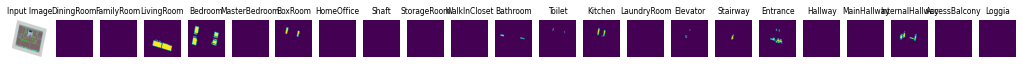

In [10]:
for inp_img, space_func__img in test_dataset.take(2):
    plt.figure(figsize=(18,18))
    display_list = [inp_img[13,:,:,:]*.5+.5]
    display_title = ['Input Image']
    
    for i,title in enumerate(SEG_CLASSES.keys()):
        display_list.append(space_func__img[13,:,:,i])
        display_title.append(title)

    for i in range(len(SEG_CLASSES.keys())+1):
        plt.subplot(1, len(SEG_CLASSES.keys())+1, i+1)
        plt.title(display_title[i], fontsize=7.5)
        plt.imshow(display_list[i] )
        plt.axis('off')
    plt.show()

### 4. Build VGG16 U-Net

In [11]:
# Using Transfer Learning
vgg16_unet_model = get_vgg16_unet_model (input_size=(HEIGHT, WIDTH, 3), n_labels=OUTPUT_CHANNELS)

adam = tf.keras.optimizers.Adam(learning_rate= 0.001, beta_1=.9, beta_2=.999, epsilon=1e-08)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),

#miou = tf.keras.metrics.MeanIoU(num_classes=OUTPUT_CHANNELS)
vgg16_unet_model.compile(optimizer = adam, loss = loss )

In [12]:
vgg16_unet_model  = tf.keras.models.load_model('./vgg16_unet_model')

### 5. Train VGG16 U-Net

In [12]:
# Train from scratch the decoder with a learning rate of 0.001
# and an epoch number of 100, while the pre-trained U2-Net encoder layers are frozen.

vgg16_unet_model.fit(train_dataset,epochs= 100)

Epoch 1/100
18/18 [==============================] - 11s 134ms/step - loss: 0.1294
Epoch 2/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0328
Epoch 3/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0257
Epoch 4/100
18/18 [==============================] - 5s 141ms/step - loss: 0.0246
Epoch 5/100
18/18 [==============================] - 5s 137ms/step - loss: 0.0239
Epoch 6/100
18/18 [==============================] - 5s 134ms/step - loss: 0.0237
Epoch 7/100
18/18 [==============================] - 5s 134ms/step - loss: 0.0241
Epoch 8/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0231
Epoch 9/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0228
Epoch 10/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0231
Epoch 11/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0218
Epoch 12/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0210
Epoch 13/100

In [13]:
# Unfreeze all the encoder layers and train them with a learning rate of 0.0001
# and an epoch number of 100, while the decoder layers are frozen.

for l in vgg16_unet_model.layers:
    if 'up'  in l.name:
        l.trainable = False
    else:
        l.trainable = True

adam.learning_rate.assign(0.0001)
vgg16_unet_model.fit(train_dataset,epochs= 100)

Epoch 1/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0085
Epoch 2/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0077
Epoch 3/100
18/18 [==============================] - 5s 134ms/step - loss: 0.0080
Epoch 4/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0074
Epoch 5/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0072
Epoch 6/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0072
Epoch 7/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0067
Epoch 8/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0068
Epoch 9/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0072
Epoch 10/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0071
Epoch 11/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0070
Epoch 12/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0069
Epoch 13/100


In [14]:
## Unfreeze both the decoder and encoder and train them simultaneously 
# with a learning rate of 0.00009 and an epoch number of 100.

for l in vgg16_unet_model.layers:
    l.trainable = True
    
adam.learning_rate.assign(0.00009)
vgg16_unet_model.fit(train_dataset,epochs= 100)

Epoch 1/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0044
Epoch 2/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0045
Epoch 3/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0045
Epoch 4/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0047
Epoch 5/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0044
Epoch 6/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0044
Epoch 7/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0043
Epoch 8/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0047
Epoch 9/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0041
Epoch 10/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0045
Epoch 11/100
18/18 [==============================] - 5s 135ms/step - loss: 0.0042
Epoch 12/100
18/18 [==============================] - 5s 136ms/step - loss: 0.0043
Epoch 13/100


In [23]:
vgg16_unet_model.save('./vgg16_unet_model')

INFO:tensorflow:Assets written to: ./vgg16_unet_model\assets


### 5. Evaluate VGG16 U-Net

In [13]:
X_test, y_test = next(iter(test_dataset))
y_pred = vgg16_unet_model.predict(X_test)

In [14]:
y_pred.shape, y_test.shape

((14, 320, 320, 22), TensorShape([14, 320, 320, 22]))

In [15]:
MIoU, iou_per_class, ious_per_class = mIoU(y_pred, y_test,  threshold=0.5, target_class_ids=[1])

In [16]:
for k,item in SEG_CLASSES.items():
    print('{}, {}, IoUs: {}, IoU: {}'.format(item.id, item.name, ious_per_class[item.id-1], iou_per_class[item.id-1]))

1, DiningRoom, IoUs: [0.   0.33 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ], IoU: 0.02
2, FamilyRoom, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
3, LivingRoom, IoUs: [0.93 0.95 0.97 0.94 0.96 0.94 0.96 0.95 0.97 0.92 0.92 0.96 0.87 0.97], IoU: 0.94
4, Bedroom, IoUs: [0.92 0.92 0.   0.91 0.95 0.87 0.91 0.91 0.73 0.92 0.87 0.91 0.9  0.94], IoU: 0.83
5, MasterBedroom, IoUs: [0.   0.   0.94 0.   0.79 0.32 0.   0.   0.6  0.   0.33 0.   0.   0.  ], IoU: 0.21
6, BoxRoom, IoUs: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.89], IoU: 0.06
7, HomeOffice, IoUs: [0.   0.   0.   0.   0.75 0.   0.   0.   0.   0.   0.   0.   0.   0.  ], IoU: 0.05
8, Shaft, IoUs: [0.08 0.   0.   0.08 0.09 0.03 0.01 0.   0.11 0.   0.   0.25 0.   0.  ], IoU: 0.05
9, StorageRoom, IoUs: [0.   0.   0.   0.29 0.   0.17 0.31 0.   0.   0.73 0.   0.   0.   0.  ], IoU: 0.11
10, WalkInCloset, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
11, Bathroom, IoUs: [0

In [17]:
# LivingRoom IoU, exclude zeros, sum all, dividev by Test layout count from the paper
round((0.93 + 0.95 + 0.97 +0.94 +0.96 +0.94+ 0.96+ 0.95+ 0.97 +0.92 +0.92+ 0.96 +0.87+ 0.97) / 14, 2)

0.94

In [16]:
mean_f1_Measure, f1_Measures = f1_measure(y_test, y_pred)

In [17]:
for k,item in SEG_CLASSES.items():
    print('{}, {}, F_measure: {}'.format(item.id, item.name, f1_Measures[item.id-1]))

1, DiningRoom, F_measure: 0.49
2, FamilyRoom, F_measure: 0.0
3, LivingRoom, F_measure: 0.97
4, Bedroom, F_measure: 0.95
5, MasterBedroom, F_measure: 0.88
6, BoxRoom, F_measure: 0.94
7, HomeOffice, F_measure: 0.85
8, Shaft, F_measure: 0.13
9, StorageRoom, F_measure: 0.49
10, WalkInCloset, F_measure: 0.0
11, Bathroom, F_measure: 0.83
12, Toilet, F_measure: 0.46
13, Kitchen, F_measure: 0.91
14, LaundryRoom, F_measure: 0.22
15, Elevator, F_measure: 0.83
16, Stairway, F_measure: 0.94
17, Entrance, F_measure: 0.79
18, Hallway, F_measure: 0.7
19, MainHallway, F_measure: 0.83
20, InternalHallway, F_measure: 0.72
21, AccessBalcony, F_measure: 0.95
22, Loggia, F_measure: 0.95


In [18]:
Mtotal_error, total_error_per_class, total_errors_per_class = total_error(y_pred, y_test)

In [19]:
for k,item in SEG_CLASSES.items():
    print('{}, {}, Total error: {}'.format(item.id, item.name, total_error_per_class[item.id-1]))

1, DiningRoom, Total error: 0.0
2, FamilyRoom, Total error: 0.0
3, LivingRoom, Total error: 0.005
4, Bedroom, Total error: 0.004
5, MasterBedroom, Total error: 0.002
6, BoxRoom, Total error: 0.0
7, HomeOffice, Total error: 0.0
8, Shaft, Total error: 0.001
9, StorageRoom, Total error: 0.001
10, WalkInCloset, Total error: 0.0
11, Bathroom, Total error: 0.003
12, Toilet, Total error: 0.001
13, Kitchen, Total error: 0.001
14, LaundryRoom, Total error: 0.001
15, Elevator, Total error: 0.001
16, Stairway, Total error: 0.001
17, Entrance, Total error: 0.002
18, Hallway, Total error: 0.0
19, MainHallway, Total error: 0.001
20, InternalHallway, Total error: 0.002
21, AccessBalcony, Total error: 0.001
22, Loggia, Total error: 0.0


In [20]:
X_test_path

['./data\\0066\\input\\0066_input.png',
 './data\\0065\\input\\0065_input.png',
 './data\\0030\\input\\0030_input.png',
 './data\\0063\\input\\0063_input.png',
 './data\\0009\\input\\0009_input.png',
 './data\\0044\\input\\0044_input.png',
 './data\\0052\\input\\0052_input.png',
 './data\\0039\\input\\0039_input.png',
 './data\\0015\\input\\0015_input.png',
 './data\\0040\\input\\0040_input.png',
 './data\\0001\\input\\0001_input.png',
 './data\\0037\\input\\0037_input.png',
 './data\\0004\\input\\0004_input.png',
 './data\\0005\\input\\0005_input.png']

### 6. Visualize

(14, 320, 320, 3) (14, 320, 320, 22)


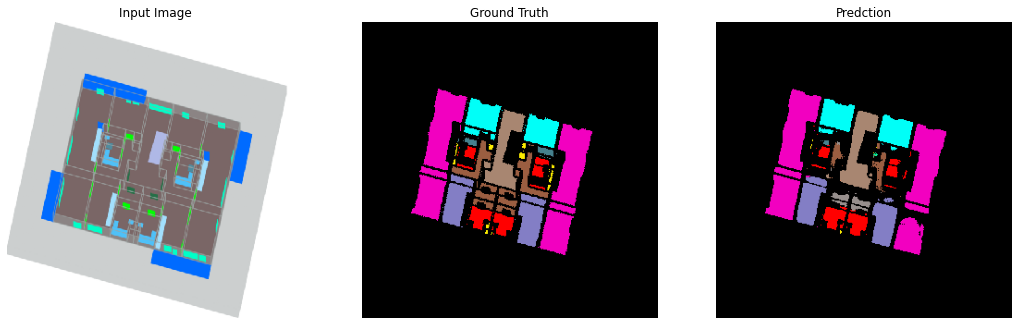

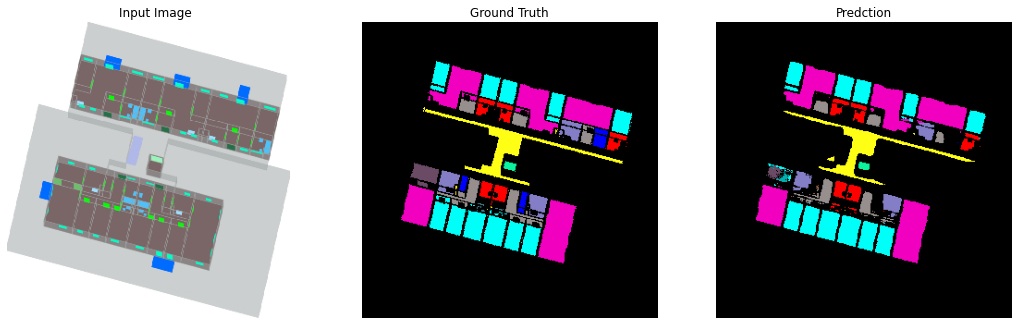

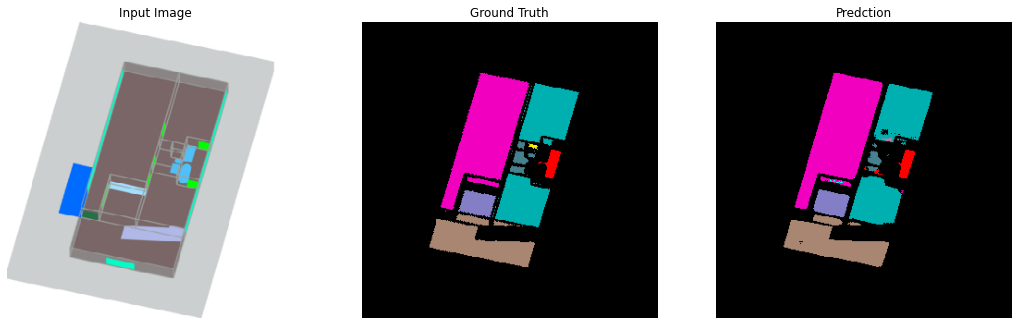

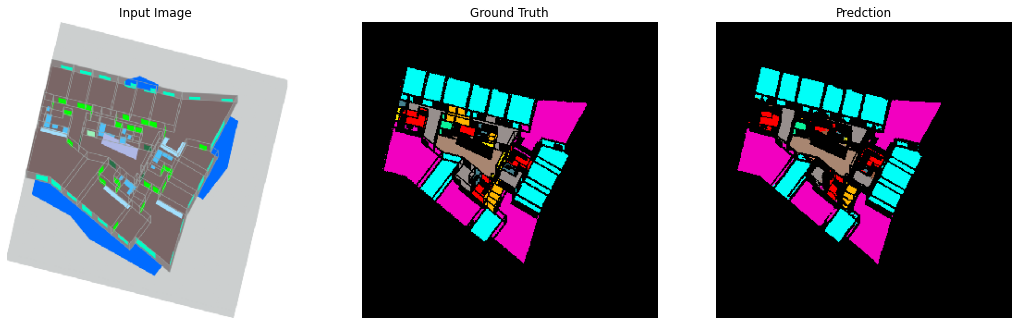

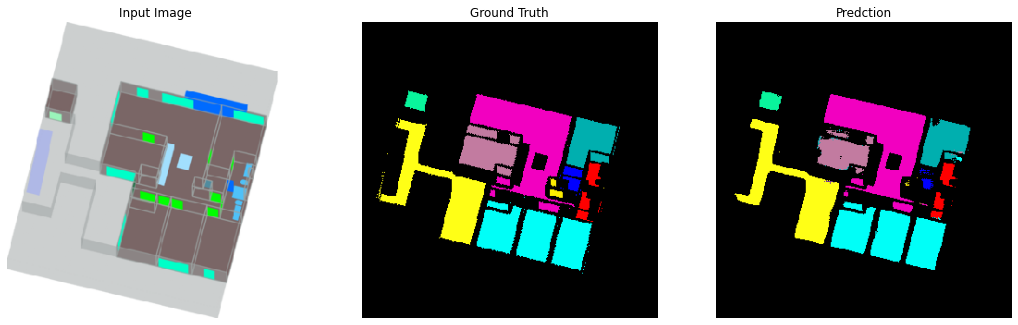

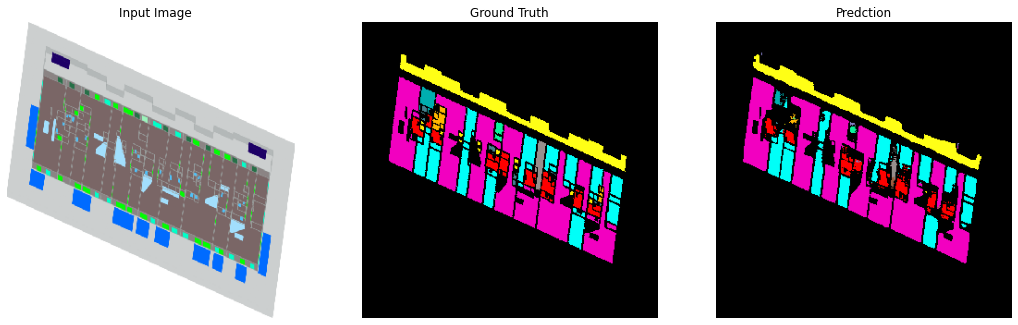

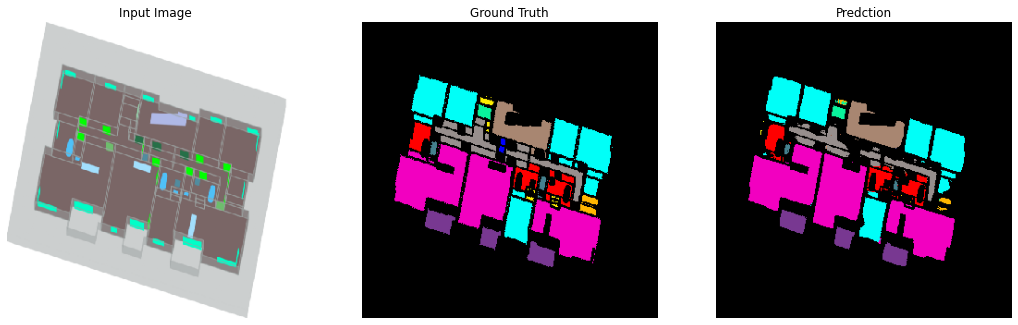

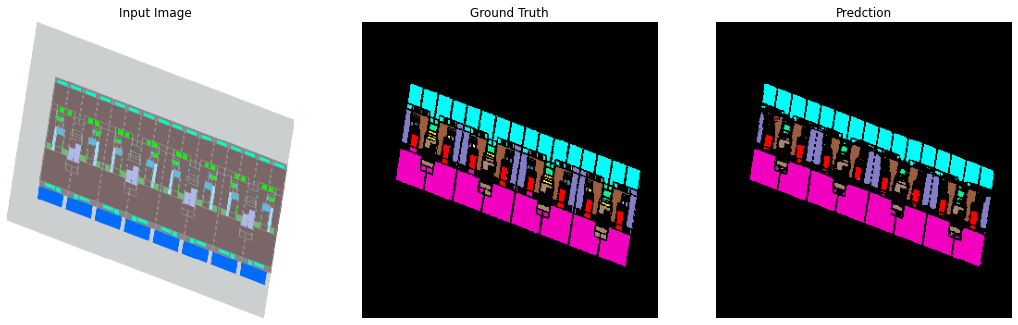

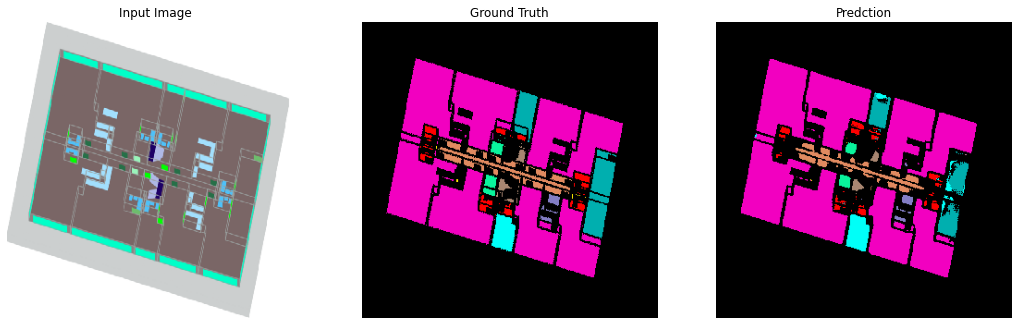

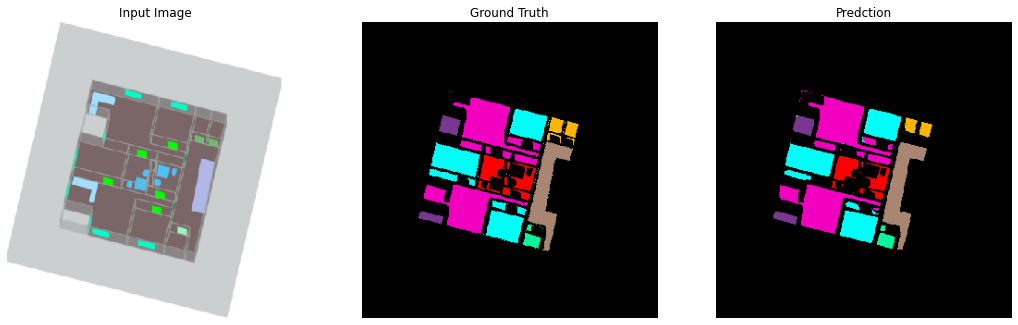

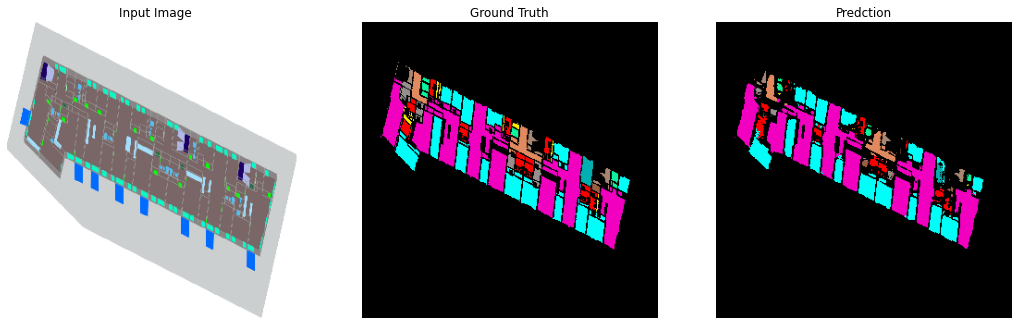

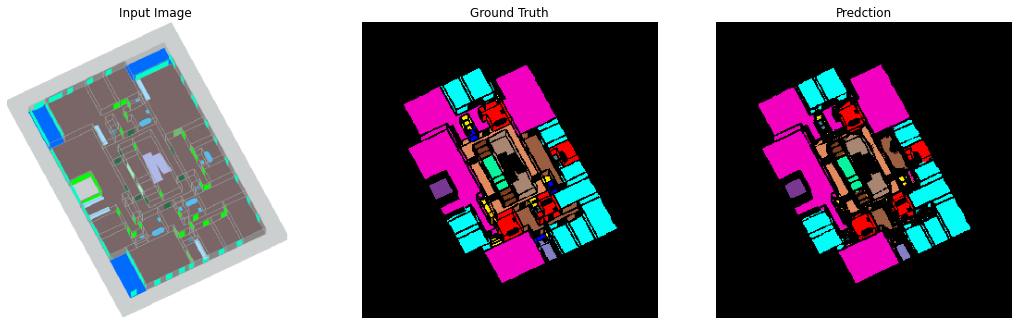

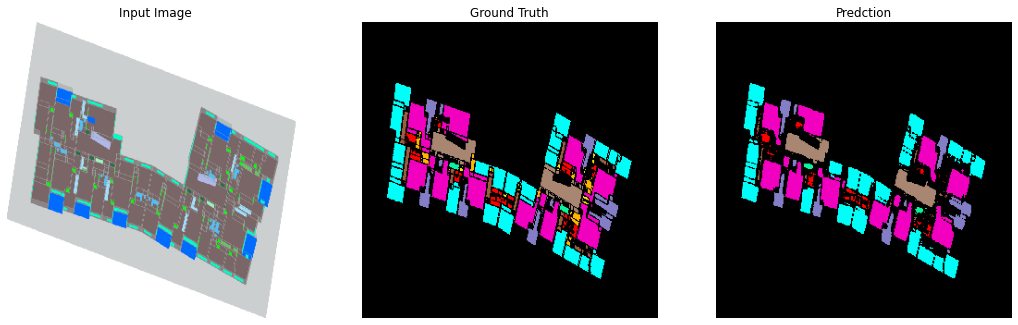

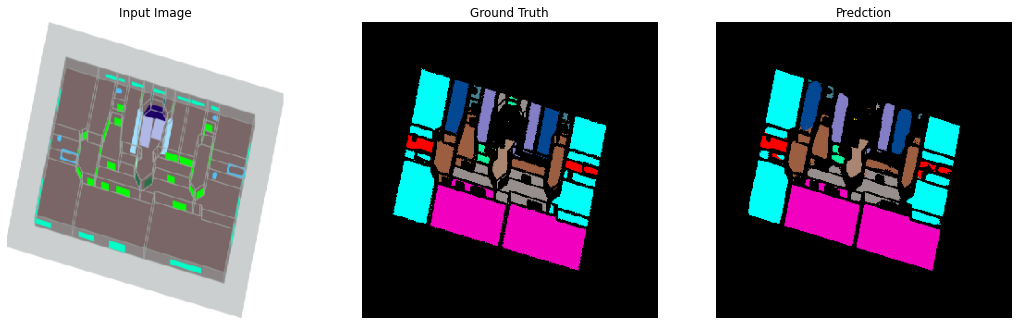

In [21]:
print(X_test.shape, y_pred.shape)

for i, path in enumerate(X_test_path):
    name = path.split('\\')[1]
    visulaize_inp_pred_gt(X_test[i], y_pred[i], y_test[i], HEIGHT, WIDTH, SEG_CLASSES, pred_path, name, save=True)